In [47]:
# --- Sanity check: vis 25 s EKG 5 timer inde i en TDMS-optagelse ---
# Kræver: pip install nptdms matplotlib numpy

from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime

def load_tdms_segment(path_tdms, start_time_s, duration_s=25.0, channel_name=None, fs_override=None):
    """
    Returnerer (t, x, fs, meta) for et udsnit af længde 'duration_s' der starter 'start_time_s' sekunder
    efter optagelsesstart. Vælger første kanal hvis channel_name ikke angives.
    """
    td = TdmsFile.read(str(path_tdms))

    # Vælg gruppe/kanal
    g = td.groups()[0]
    ch = None
    if channel_name is None:
        ch = g.channels()[0]
    else:
        for c in g.channels():
            if c.name == channel_name:
                ch = c
                break
        if ch is None:
            raise ValueError(f"Kanalen '{channel_name}' blev ikke fundet. Tilgængelige: {[c.name for c in g.channels()]}")

    # Rådata (float)
    x_all = ch.data.astype(float)

    # Samplingfrekvens
    inc = ch.properties.get("wf_increment", None)  # sekunder/sample
    fs = None
    if inc is not None:
        fs = 1.0 / inc
    if fs_override is not None:
        fs = fs_override
    if fs is None:
        raise ValueError("Samplingfrekvens kunne ikke bestemmes (wf_increment mangler). Angiv fs_override.")

    # Starttid (hvis tilgængelig – kun til info)
    wf_start = ch.properties.get("wf_start_time", None)
    # Bemærk: vi bruger uanset hvad 'start_time_s' relativt til filstart

    # Indeksberegning
    n0 = int(round(start_time_s * fs))
    n1 = n0 + int(round(duration_s * fs))
    if n0 < 0:
        raise ValueError("Startindeks bliver negativt – tjek start_time_s.")
    if n0 >= len(x_all):
        raise ValueError("Start ligger efter filens slutning.")
    n1 = min(n1, len(x_all))

    x = x_all[n0:n1]
    t = np.arange(len(x)) / fs  # lokal tidsskala (sekunder)

    meta = {
        "fs": fs,
        "n_total": len(x_all),
        "segment_start_index": n0,
        "segment_end_index": n1,
        "wf_start_time": wf_start,  # kan være None
    }
    return t, x, x_all, fs, meta

# -----------------------------
# KONFIGURATION
patientId = 5
# path = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch - Corrected\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
path = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
   # <-- SKIFT denne
channel = None                     # fx "ECG" eller lad None for første kanal
fs_override = None                 # fx 256.0 hvis wf_increment mangler
hours_after_start = 35.8            # 5 timer
duration_s = 200                  # 25 sekunder
# Angiv anfaldstidspunkt her (ISO-format anbefales: "YYYY-MM-DD HH:MM:SS")
# seizure_timestamp_start = "2016-10-13 07:26:30"  # <-- SKIFT til dit anfaldstidspunkt
# seizure_timestamp_end = "2016-10-13 07:28:57"    # <-- SKIFT til dit anfaldstidspunkt
seizure_timestamp_start = "2016-10-13 14:47:30"  # <-- SKIFT til dit anfaldstidspunkt
seizure_timestamp_end = "2016-10-13 14:49:24"    # <-- SKIFT til dit anfaldstidspunkt
# ------------------------------

# Hent wf_start_time fra TDMS-filen (første gruppe/kanal)
td_meta = TdmsFile.read(str(path))
g0 = td_meta.groups()[0]
ch0 = g0.channels()[0]

for k, v in ch0.properties.items():
    print(f"{k}: {v}")

# wf_start = ch0.properties.get("wf_start_time", None)
wf_start = ch0.properties.get("NI_ExpStartTimeStamp_original", None) # alternativt

if wf_start is None:
    raise ValueError("wf_start_time mangler i TDMS-filen. Kan ikke beregne forskel. Sæt hours_after_start manuelt.")

# Sikr at wf_start er et datetime-objekt (ellers forvent ISO-streng eller numpy.datetime64/pandas.Timestamp)
if isinstance(wf_start, str):
    try:
        wf_start_dt = datetime.fromisoformat(wf_start)
    except Exception:
        raise ValueError("Kan ikke parse wf_start_time-strengen. Forvent ISO-format.")
else:
    # Hvis wf_start er en numpy.datetime64, konverter til python datetime
    if isinstance(wf_start, np.datetime64):
        try:
            wf_start_dt = wf_start.tolist()  # konverterer til datetime.datetime
        except Exception:
            # fallback: konverter via seconds-since-epoch
            wf_start_dt = datetime.utcfromtimestamp(wf_start.astype('datetime64[s]').astype(int))
    # Hvis wf_start er en pandas.Timestamp eller lignende objekt med to_pydatetime
    elif hasattr(wf_start, "to_pydatetime"):
        try:
            wf_start_dt = wf_start.to_pydatetime()
        except Exception:
            wf_start_dt = wf_start
    else:
        wf_start_dt = wf_start

# Parse brugerens anfaldstid
try:
    seizure_dt = datetime.fromisoformat(seizure_timestamp_start)
except Exception:
    raise ValueError("Kan ikke parse seizure_timestamp. Brug ISO-format: 'YYYY-MM-DD HH:MM:SS'.")

# Beregn forskel
delta = seizure_dt - wf_start_dt
start_time_s = delta.total_seconds()
hours_after_start = start_time_s / 3600.0

print(f"Filstart: {wf_start_dt}")
print(f"Anfaldstid: {seizure_dt}")
print(f"Forskel: {delta} ({start_time_s:.1f} s = {hours_after_start:.4f} h)")

# Nu overskriver vi hours_after_start så resterende kode bruger anfaldspositionen
# -----------------------------

start_time_s = hours_after_start * 3600.0
t, x, x_all, fs, meta = load_tdms_segment(path, start_time_s, duration_s, channel, fs_override)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t, x, lw=1)
plt.xlabel("Tid (s) fra")
plt.ylabel("Amplitude (a.u.)")
title_right = ""
if meta["wf_start_time"] is not None:
    # vis human læsbar absolut start for segmentet (hvis tilgængeligt)
    try:
        abs_seg_start = meta["wf_start_time"] + timedelta(seconds=start_time_s)
        title_right = f" | Segment starter: {abs_seg_start}"
    except Exception:
        pass

plt.title(f"EKG-udsnit på {duration_s:.0f} s, {hours_after_start:.0f} timer inde (fs={meta['fs']:.2f} Hz){title_right}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"fs = {meta['fs']:.3f} Hz | segment [{meta['segment_start_index']} : {meta['segment_end_index']}] af i alt {meta['n_total']}")


wf_start_time: 2016-10-12T09:05:02.000000
wf_start_offset: 0.0
wf_increment: 0.001953125
wf_samples: 82460288
DigitalMaximum: 32767
DigitalMinimum: -32768
NI_ChannelName: EKG
NI_ExpIsRelativeTime: False
wf_time_pref: absolute
NI_ExpStartTimeStamp: 2016-10-12T09:05:02.000000
NI_ExpTimeStamp: 2016-10-12T09:05:02.000000
NI_ExpXDimension: t
wf_xname: Time
wf_xunit_string: s
NI_UnitDescription: uV
unit_string: uV
PhysicalMaximum: 90298.0
PhysicalMinimum: -90298.0
PreFilter: 
TransducerType: 
ValsPerRec: 128


ValueError: wf_start_time mangler i TDMS-filen. Kan ikke beregne forskel. Sæt hours_after_start manuelt.

In [54]:
# path = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch - Corrected\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
# path = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
path = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 6\recording 1\Patient 6_1.tdms"
xfile = TdmsFile(path, read_metadata_only=True)

In [55]:
# Print groups and channels in xfile
print(xfile.groups())
for group in xfile.groups():
    print(f"Group: {group.name}")
    for channel in group.channels():
        print(f"  Channel: {channel.name}")
        for k, v in channel.properties.items():
            print(f"    {k}: {v}")

[<TdmsGroup with path /'Untitled'>]
Group: Untitled
  Channel: EKG
    wf_start_time: 2017-01-23T12:57:31.000000
    wf_start_offset: 0.0
    wf_increment: 0.001953125
    wf_samples: 88105472
    DigitalMaximum: 32767
    DigitalMinimum: -32768
    NI_ChannelName: EKG
    NI_ExpIsRelativeTime: False
    wf_time_pref: absolute
    NI_ExpStartTimeStamp: 2017-01-23T12:57:31.000000
    NI_ExpTimeStamp: 2017-01-23T12:57:31.000000
    NI_ExpXDimension: t
    wf_xname: Time
    wf_xunit_string: s
    NI_UnitDescription: uV
    unit_string: uV
    PhysicalMaximum: 90298.0
    PhysicalMinimum: -90298.0
    PreFilter: 
    TransducerType: 
    ValsPerRec: 128


In [2]:
print(x.shape)  # (51200,)

102400/512

(102400,)


200.0

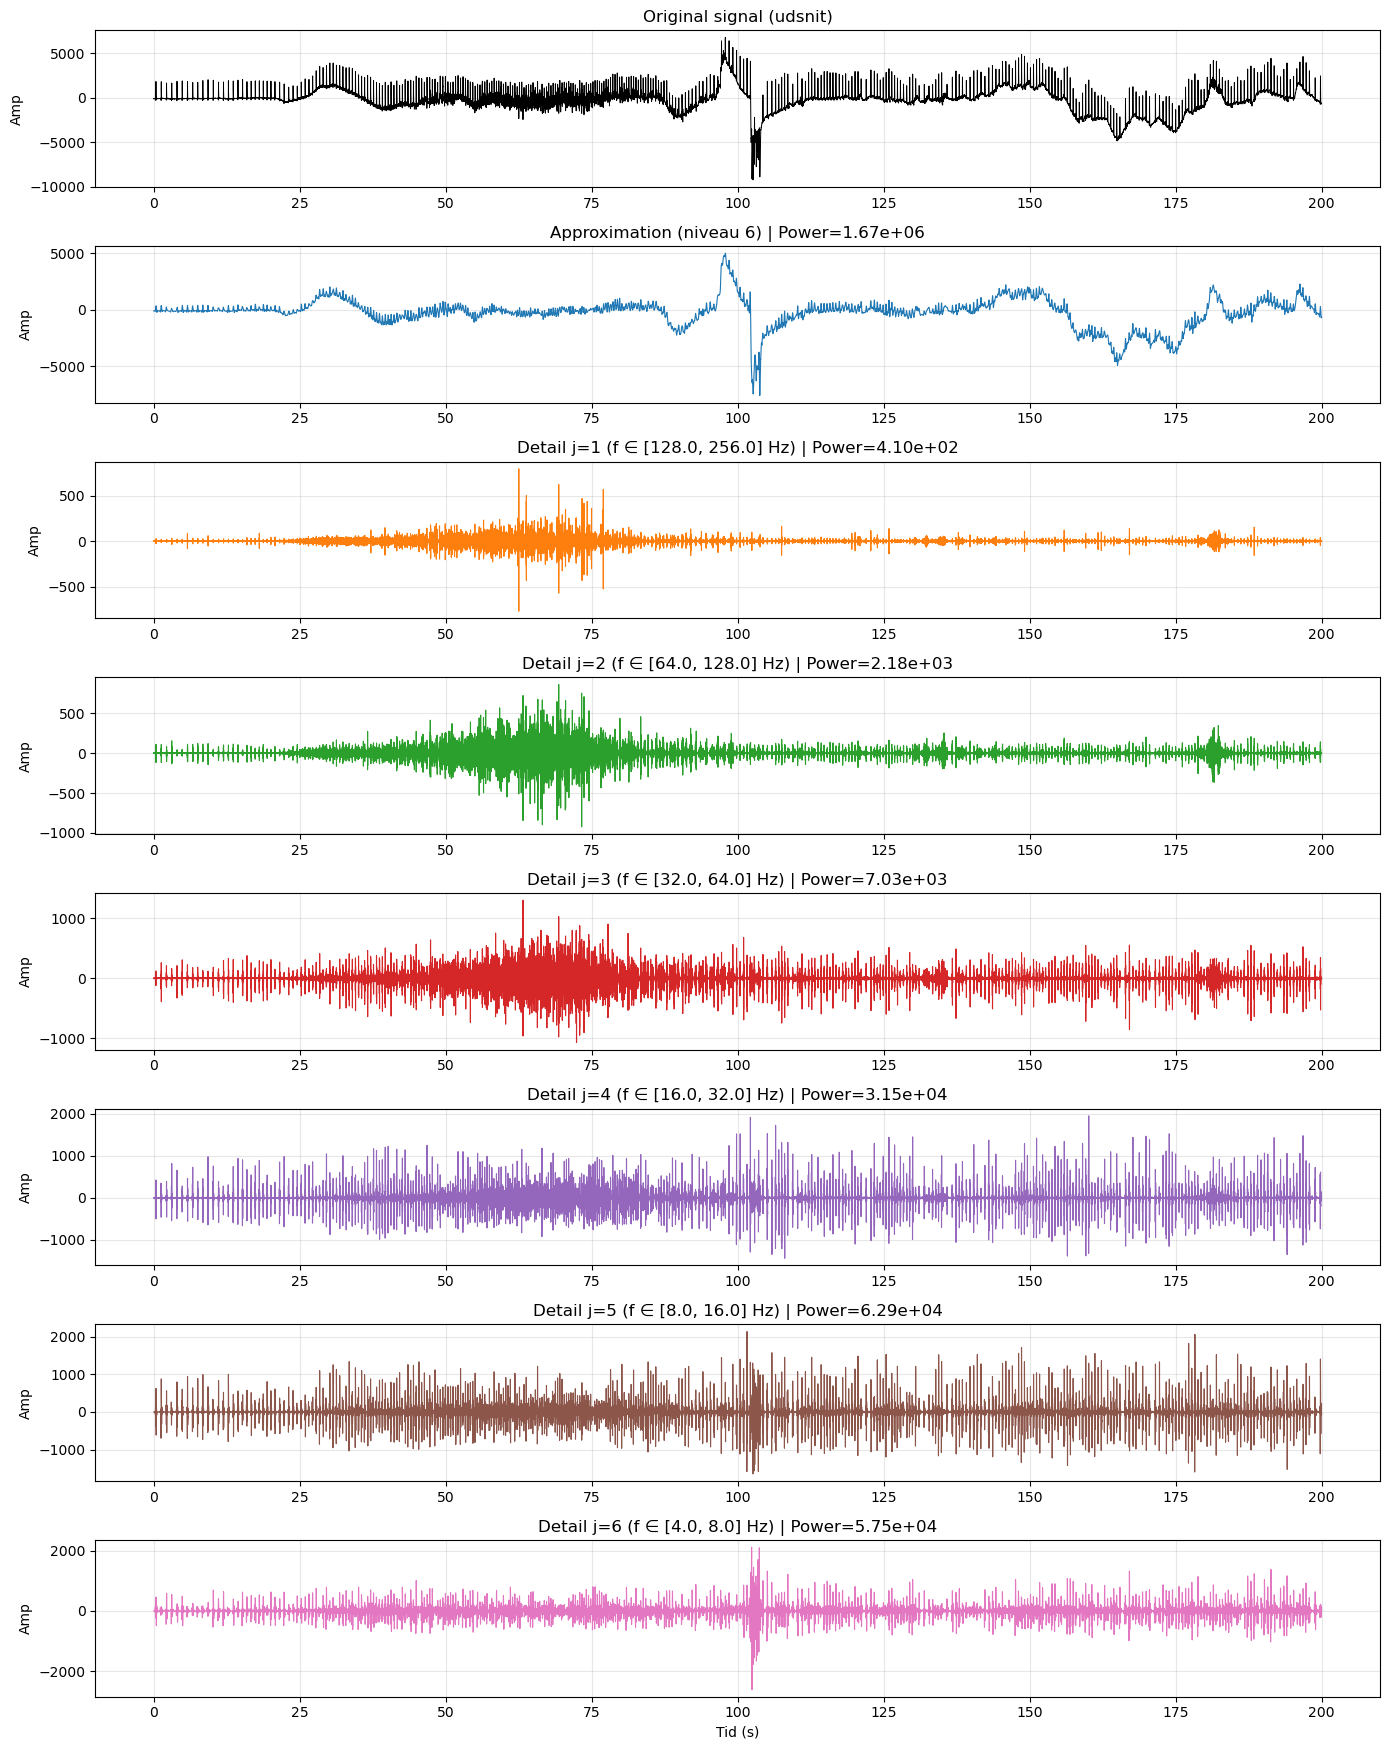

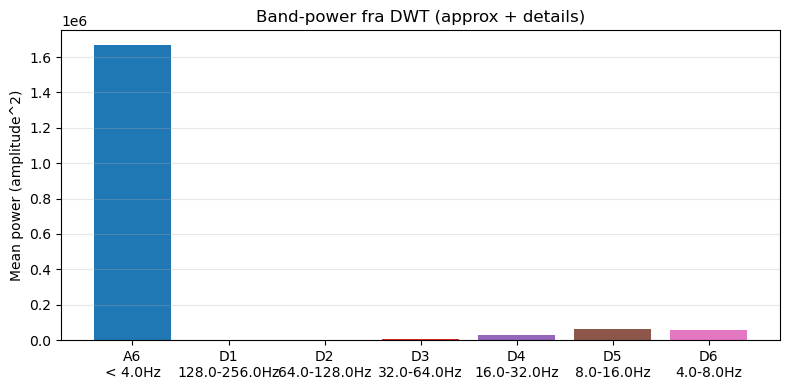

In [3]:
import pywt

# DWT-analyse af den indlæste signal-udsnit (brug eksisterende x, t, fs)
# Kræver: pip install PyWavelets

# try:
# except Exception as e:
#     raise ImportError("PyWavelets (pywt) mangler. Installer med: pip install PyWavelets") from e

# Konfiguration
wavelet = "db4"                       # vælg wavelet (f.eks. 'db4' velegnet til EKG)
max_level = pywt.dwt_max_level(len(x), pywt.Wavelet(wavelet).dec_len)
level = min(max_level, 6)             # begræns antal niveauer vist (tilpas efter behov)

# Dekomponér
coeffs = pywt.wavedec(x, wavelet, level=level)   # coeffs = [cA_n, cD_n, cD_{n-1}, ..., cD1]

# Hjælpefunktion til rekonstruktion af en enkelt detailniveau j (1 = fineste)
def reconstruct_detail(coeffs, wavelet, level, j):
    # index i i coeffs for detail j: i = level - j + 1
    idx = level - j + 1
    coeffs_zero = [np.zeros_like(c) for c in coeffs]
    coeffs_zero[idx] = coeffs[idx]
    rec = pywt.waverec(coeffs_zero, wavelet)
    return rec[:len(x)]

# Rekonstruer alle detaljer og approximation
reconstructed_details = []
powers = []
freq_bands = []
for j in range(1, level + 1):
    rec = reconstruct_detail(coeffs, wavelet, level, j)
    reconstructed_details.append(rec)
    # Estimeret frekvensbånd for detail j: [fs/2^{j+1}, fs/2^{j}]
    f_low = fs / (2 ** (j + 1))
    f_high = fs / (2 ** j)
    freq_bands.append((f_low, f_high))
    powers.append(np.mean(rec ** 2))

# Rekonstruer approximation (lavfrekvensindhold)
coeffs_approx = [np.zeros_like(c) for c in coeffs]
coeffs_approx[0] = coeffs[0]
approx_rec = pywt.waverec(coeffs_approx, wavelet)[:len(x)]
approx_power = np.mean(approx_rec ** 2)

# Plot original, approximation og detaljer
n_plots = 2 + len(reconstructed_details)  # original + approx + details
plt.figure(figsize=(14, 2.2 * n_plots))

plt.subplot(n_plots, 1, 1)
plt.plot(t, x, color="k", lw=0.7)
plt.title("Original signal (udsnit)")
plt.ylabel("Amp")
plt.grid(alpha=0.3)

plt.subplot(n_plots, 1, 2)
plt.plot(t, approx_rec, color="C0", lw=0.8)
plt.title(f"Approximation (niveau {level}) | Power={approx_power:.2e}")
plt.ylabel("Amp")
plt.grid(alpha=0.3)

for i, rec in enumerate(reconstructed_details, start=1):
    plt.subplot(n_plots, 1, 2 + i)
    plt.plot(t, rec, color=f"C{i}", lw=0.8)
    f_low, f_high = freq_bands[i - 1]
    plt.title(f"Detail j={i} (f ∈ [{f_low:.1f}, {f_high:.1f}] Hz) | Power={powers[i - 1]:.2e}")
    plt.ylabel("Amp")
    plt.grid(alpha=0.3)

plt.xlabel("Tid (s)")
plt.tight_layout()
plt.show()

# Bar-plot af power per band (inkl. approximation)
labels = [f"D{j}\n{freq_bands[j-1][0]:.1f}-{freq_bands[j-1][1]:.1f}Hz" for j in range(1, level+1)]
labels.insert(0, f"A{level}\n< {freq_bands[-1][0]:.1f}Hz")
bar_vals = [approx_power] + powers

plt.figure(figsize=(8,4))
plt.bar(labels, bar_vals, color=["C0"] + [f"C{(i%10)}" for i in range(1, len(powers)+1)])
plt.ylabel("Mean power (amplitude^2)")
plt.title("Band-power fra DWT (approx + details)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

seizure_start = 99748.000 s, seizure_end = 99862.000 s (relativt til filstart)


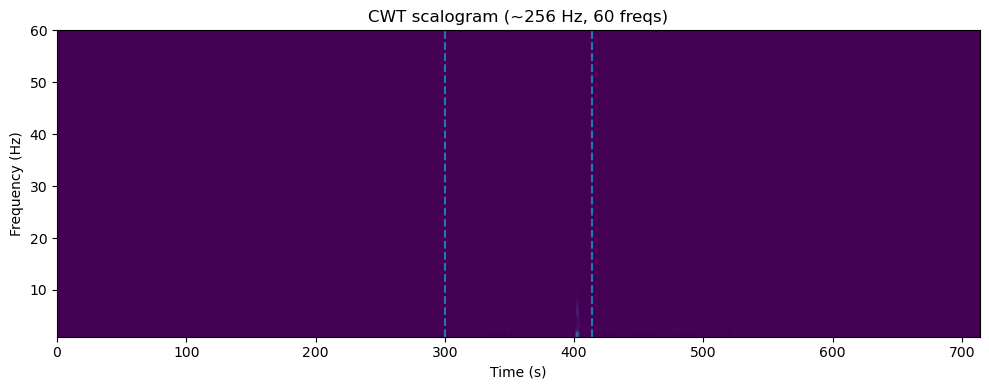

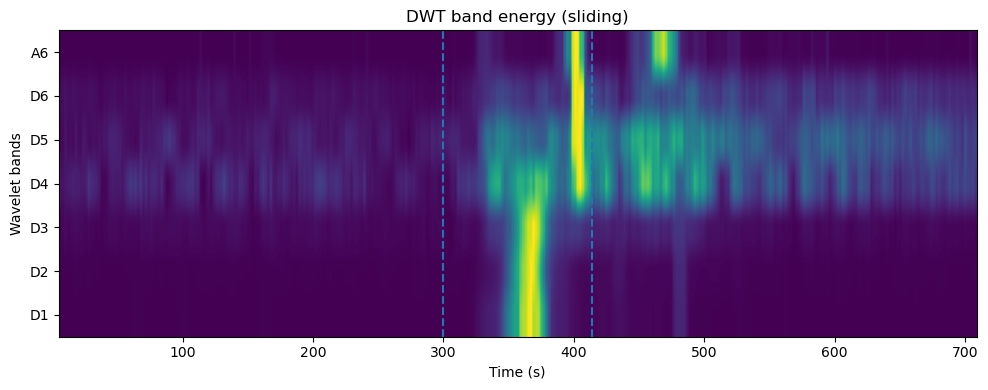

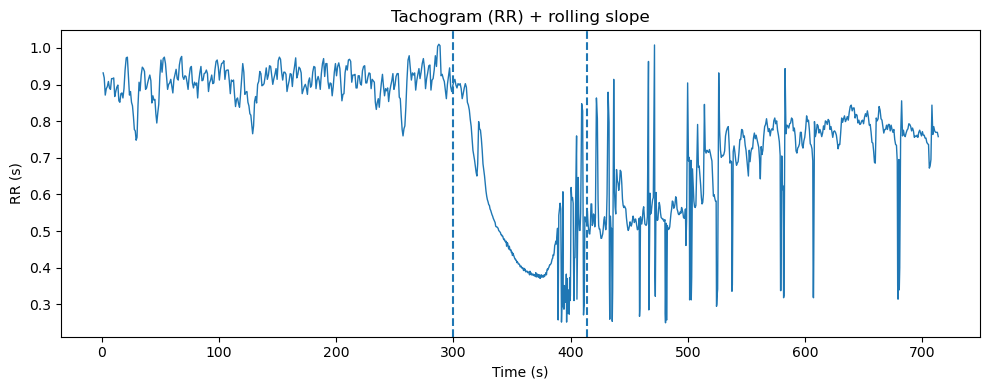

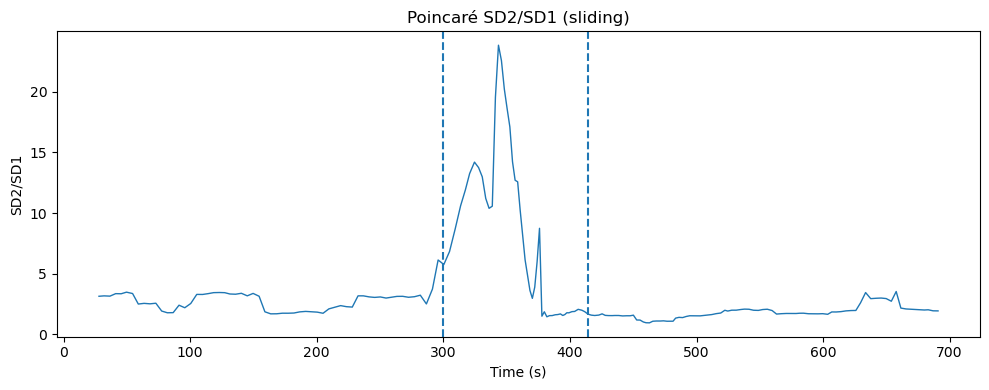

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ekg_seizure_analysis import analyze_segment_window

# Beregn seizure_start/seizure_end (sekunder relativt til hele optagelsen x_all)
try:
    s_start_raw = seizure_timestamp_start
    s_end_raw = seizure_timestamp_end
except NameError:
    try:
        s_start_raw = seizure_timestamp
        s_end_raw = seizure_timestamp
    except NameError:
        raise NameError("Definer 'seizure_timestamp_start' og 'seizure_timestamp_end' (ISO-strenge eller datetime-objekter).")

def _to_dt(v):
    if isinstance(v, datetime):
        return v
    if isinstance(v, str):
        return datetime.fromisoformat(v)
    if isinstance(v, np.datetime64):
        return v.tolist()
    if hasattr(v, "to_pydatetime"):
        return v.to_pydatetime()
    raise ValueError(f"Kan ikke konvertere {type(v)} til datetime.")

s_start_dt = _to_dt(s_start_raw)
s_end_dt = _to_dt(s_end_raw)

# Find wf-start (brug allerede beregnet wf_start_dt hvis tilgængelig, ellers fra meta)
try:
    wf_dt = wf_start_dt
except NameError:
    wf_val = meta.get("wf_start_time", None)
    if wf_val is None:
        raise ValueError("wf_start_time ikke tilgængelig. Kan ikke beregne relative tider.")
    wf_dt = _to_dt(wf_val)

seizure_start = float((s_start_dt - wf_dt).total_seconds())
seizure_end = float((s_end_dt - wf_dt).total_seconds())

# Valider og vis
record_dur_s = len(x_all) / float(fs)
if seizure_start < 0 or seizure_end < 0 or seizure_start > record_dur_s or seizure_end > record_dur_s:
    print(f"Advarsel: anfaldstider uden for optagelsesvarighed ({seizure_start:.1f}s - {seizure_end:.1f}s), optagelse = 0..{record_dur_s:.1f}s")

print(f"seizure_start = {seizure_start:.3f} s, seizure_end = {seizure_end:.3f} s (relativt til filstart)")

res = analyze_segment_window(
    x_all, fs,
    seizure_t0=seizure_start,   # sekunder relativt til x_all-start
    seizure_t1=seizure_end,     # sekunder relativt til x_all-start
    pad_pre_s=300.0,            # 5 min før
    pad_post_s=300.0,           # 5 min efter
    wavelet="db4",
    dwt_level=6,
    rr_win_beats=60,
    rr_step_beats=5,
    do_cwt=True,                # slå fra hvis du vil springe CWT over
    cwt_target_fs=200.0,        # nedprøver før CWT (120 Hz default)
    cwt_n_freqs=60              # reduceret frekvensgrid for lavere RAM
)




In [5]:
# Get time from start of recording to seizure start and end in hours, minutes, seconds
def format_time_hms(total_seconds):
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    return hours, minutes, seconds

h_start, m_start, s_start = format_time_hms(seizure_start)
h_end, m_end, s_end = format_time_hms(seizure_end)

print(f"Seizure starts at {h_start}h {m_start}m {s_start}s and ends at {h_end}h {m_end}m {s_end}s from start of recording.")

Seizure starts at 27h 42m 28s and ends at 27h 44m 22s from start of recording.


In [7]:
from pathlib import Path
import pandas as pd

def load_labview_rr_lvm(path):
    """
    Læser en LabVIEW Measurement (LVM) fil med RR-intervaller.
    Forventer linje: 'X_Value\tUntitled\tComment' (Comment kan mangle).
    Håndterer decimalkomma og flere segmenter.

    Param
    -----
    path : str | Path

    Return
    ------
    df : pandas.DataFrame
        Kolonner:
          - segment  : int (0,1,2,..)
          - x_index  : int/float (fra X_Value-kolonnen)
          - rr_s     : float (RR-interval i sekunder)
          - comment  : str (hvis til stede)
          - t_s      : float (kumulativ tid i sekunder baseret på rr_s)
          - hr_bpm   : float (øjeblikkelig puls i bpm = 60/rr_s)
    meta : dict
        Udvalgte headerfelter (første segment): Separator, Decimal_Separator, Date, Time, Samples, osv.
    """
    path = Path(path)
    lines = path.read_text(encoding="utf-8", errors="ignore").splitlines()

    # Opsamling
    rows = []
    meta = {}
    segment_idx = -1
    in_data = False
    have_header_meta = False
    col_count = None

    # Hjælper: prøv at læse tal med decimalkomma
    def parse_num(tok):
        tok = tok.strip().replace(",", ".")
        # tolerér tomme felter
        if tok == "" or tok.lower() == "nan":
            return float("nan")
        return float(tok)

    i = 0
    while i < len(lines):
        line = lines[i].rstrip("\n")
        # Fang nogle meta-headers (gem fra første segment)
        if not have_header_meta:
            if line.startswith("Separator"):
                meta["Separator"] = line.split("\t",1)[-1].strip()
            elif line.startswith("Decimal_Separator"):
                meta["Decimal_Separator"] = line.split("\t",1)[-1].strip()
            elif line.startswith("Date"):
                meta["Date"] = line.split("\t",1)[-1].strip()
            elif line.startswith("Time") and "Time_Pref" not in meta:
                # Pas på at vi ikke overskriver senere 'Time' (segment header)
                meta["Time"] = line.split("\t",1)[-1].strip()
            elif line.startswith("Samples"):
                # Kan også komme i segment header; det er OK
                meta["Samples"] = line.split("\t",1)[-1].strip()

        # Start på et nyt segment, når vi ser en kolonne-linje
        if line.startswith("X_Value"):
            # Bestem kolonner (X_Value, Untitled, [Comment]?).
            headers = [h.strip() for h in line.split("\t")]
            # Forvent mindst 2 kolonner
            if len(headers) < 2:
                raise ValueError(f"For få kolonner i data-header: {headers}")
            col_count = len(headers)
            segment_idx += 1
            in_data = True
            have_header_meta = True  # fremover behøver vi ikke global meta

            # Næste linjer: data indtil tom linje / ny header / EOF
            i += 1
            while i < len(lines):
                dl = lines[i].strip()
                if not dl:
                    # tom linje => slut på dette datasæt
                    break
                # afslut hvis ny header/blok starter
                if dl.startswith("***End_of_Header***") or dl.startswith("LabVIEW Measurement") or dl.startswith("X_Value"):
                    # gå tilbage én linje, så yderste while kan håndtere headeren
                    i -= 1
                    break
                parts = dl.split("\t")
                # Nogle LVM’er kan have whitespace-forskelle; beskyt mod for få mange felter
                if len(parts) < 2:
                    i += 1
                    continue
                try:
                    x_val = parse_num(parts[0])
                    rr_s  = parse_num(parts[1])
                except ValueError:
                    # Ikke data -> ud af den indre data-løkke
                    break

                comment = parts[2].strip() if (col_count >= 3 and len(parts) >= 3) else None
                rows.append({
                    "segment": segment_idx,
                    "x_index": x_val,
                    "rr_s": rr_s,
                    "comment": comment
                })
                i += 1

            in_data = False
            # den ydre while vil i++ igen; fortsæt til næste linje
        i += 1

    if not rows:
        raise ValueError("Fandt ingen data-rækker. Tjek at filen indeholder 'X_Value' data-overskrift.")

    df = pd.DataFrame(rows)
    # Afledte kolonner
    # Kumulativ tid pr. segment
    df["t_s"] = df.groupby("segment")["rr_s"].cumsum()
    # Øjeblikkelig HR
    df["hr_bpm"] = 60.0 / df["rr_s"]

    # Sortér pr. segment og x_index hvis det giver mening
    df = df.sort_values(["segment", "x_index"]).reset_index(drop=True)
    return df, meta

# ---------- Eksempel på brug ----------
# df, meta = load_labview_rr_lvm("Patient_5_RR.lvm")
# print(meta)
# print(df.head())
# # Plot (valgfrit):
# ax = df.plot(x="t_s", y="hr_bpm", title="Puls (bpm) over tid")
# ax.set_xlabel("Tid (s)")
# ax.set_ylabel("bpm")


In [20]:
# Load new rr-intervals from LabView and compare with raw ECG data
import pandas as pd
# Path to the new RR intervals CSV file
path_rr_csv = r"D:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-corrected-rr.lvm"

# Load the RR intervals
rr_data, rr_meta = load_labview_rr_lvm(path_rr_csv)
rr_intervals = rr_data['rr_s'].values  # Assuming the column is named 'rr_s'
print(f"Loaded {len(rr_intervals)} RR intervals from {path_rr_csv}")

# Compare with raw ECG data, what average HR would these RR intervals give?
avg_rr = np.nanmean(rr_intervals)  # average RR interval in seconds
if avg_rr > 0:
    avg_hr = 60 / avg_rr  # convert to beats per minute
    print(f"Average HR from RR intervals: {avg_hr:.1f} bpm")
else:
    print("Invalid RR intervals, unable to calculate HR.")

print(len(x_all), len(x_all)/512, len(rr_intervals))  # Compare lengths

Loaded 186085 RR intervals from D:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-corrected-rr.lvm
Average HR from RR intervals: 69.5 bpm
82460288 161055.25 186085


In [35]:
print(rr_meta["Time"])
# Compare with start time for x_all
print(wf_start_dt)

13:06:19,1816539465369109152
2016-10-12 11:05:02


In [29]:
from decimal import Decimal, getcontext

rr_intervals[len(rr_intervals)-10:]  # Show last 10 intervals

sub_res = 60.0

for i in range(len(rr_intervals)):
    sub_res += rr_intervals[i]

sub_res += 300.0

print(sub_res)

getcontext().prec = 50  # øg præcision hvis ønsket
print(Decimal(10) / Decimal(len(x_all)))

161045.2723429991
1.2127049568393455041049577707029109575751178555185E-7


13 R-peaks found in plotted segment.


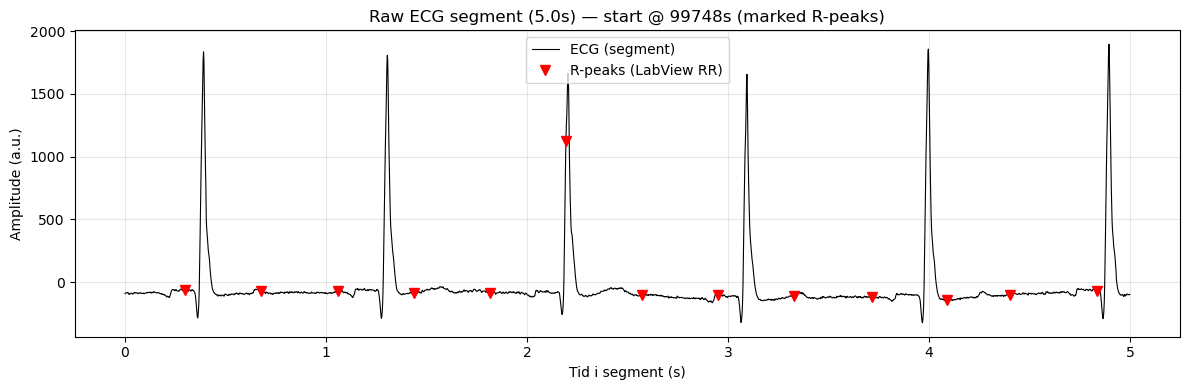

In [30]:
# Plot the loaded segment (t, x) and mark R-peaks using times from rr_data['t_s']
# Assumes rr_data, t, x, fs, start_time_s, duration_s are already defined in the notebook.

# Parameter: ønsket plot-vinduesstørrelse i sekunder (sæt til None for at bruge hele loaded segment)
plot_window_s = 5.0  # fx 5.0 eller 10.0

# Sørg for gyldige værdier og clamp til det indlæste segments længde
_orig_start = float(start_time_s)
_orig_duration = float(duration_s)
if plot_window_s is None:
    plot_window_s = _orig_duration
plot_window_s = float(plot_window_s)
# minimal varighed settes til en sample-periode for at undgå 0-længde
plot_window_s = max(1.0 / fs, min(plot_window_s, _orig_duration))

# Center vinduet omkring midten af det indlæste segment (kan ændres hvis ønskes)
_center_abs = _orig_start + _orig_duration / 2.0
_new_start_abs = _center_abs - plot_window_s / 2.0
# Hold vinduet inden for det oprindelige segment
_new_start_abs = max(_orig_start, min(_new_start_abs, _orig_start + _orig_duration - plot_window_s))

# Beregn lokale sample-indices og slice t og x
win_start_local = _new_start_abs - _orig_start
win_end_local = win_start_local + plot_window_s
idx0 = int(round(win_start_local * fs))
idx1 = int(round(win_end_local * fs))
idx0 = max(0, idx0)
idx1 = min(len(x), idx1)

t = t[idx0:idx1]
x = x[idx0:idx1]

# Opdater start_time_s og duration_s så efterfølgende kode bruger det valgte vindue
start_time_s = float(_new_start_abs)
duration_s = (len(t) / fs)

rr_times = rr_data["t_s"].values
rr_times = rr_times[~np.isnan(rr_times)]  # drop NaNs if any

seg_start = float(start_time_s)
seg_end = seg_start + float(duration_s)

# Select RR times inside the plotted segment
mask = (rr_times >= seg_start) & (rr_times <= seg_end)
rr_in_seg = rr_times[mask]

print(len(rr_in_seg), "R-peaks found in plotted segment.")

plt.figure(figsize=(12, 4))
plt.plot(t, x, lw=0.8, color="k", label="ECG (segment)")

if len(rr_in_seg) == 0:
    print("Ingen R-peaks fundet i dette segment (ingen rr_data.t_s i intervallet).")
else:
    # Convert to local segment time and sample indices
    rr_local_t = rr_in_seg - seg_start
    rr_idx = np.round(rr_local_t * fs).astype(int)
    rr_idx = np.clip(rr_idx, 0, len(x) - 1)
    rr_y = x[rr_idx]

    plt.plot(rr_local_t, rr_y, linestyle="None", marker="v", color="red",
             markersize=7, label="R-peaks (LabView RR)")

plt.xlabel("Tid i segment (s)")
plt.ylabel("Amplitude (a.u.)")
plt.title(f"Raw ECG segment ({duration_s}s) — start @ {seg_start:.0f}s (marked R-peaks)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Neurokit2
# ecg-quality PyPI

